
Image encoding with denoising autoencoders


In [ ]:
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize, rotate
from skimage.filters import gaussian
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.utils import np_utils


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#===============================================
#  Simple routine to show a row of images
#===============================================
def show_image_row(_imas, plot_size=None):
    if (plot_size != None): plt.rcParams['figure.figsize'] = [plot_size[0], plot_size[1]]
    fig, axes = plt.subplots(nrows=1, ncols=len(_imas))
    ax = axes.ravel()

    for i in range(len(_imas)):
        ax[i].imshow(_imas[i], cmap='gray')
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
#========================================================
#   Simple image plotting routine
#========================================================
def tvscale(img, wsize=-1,plot_size=(6,6)):
    plt.rcParams['figure.figsize'] = plot_size
    imgplot = plt.imshow(img,interpolation="none",cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
#========================================================
#    Create many examples of same image
#========================================================
def expand_image(_ima, _n_sam):
    
    imas_list = []
    for i in range(_n_sam):
                    
        #--- Random flips
        if (np.random.uniform(0,1) > 0.5):
            ima_i = np.fliplr(_ima)
        else:
            ima_i = np.copy(_ima)
       
        #--- Random rotation
        ima_i = rotate(ima_i, np.random.uniform(0, 360), preserve_range=True)
        
        imas_list.append(ima_i)
            
    return imas_list

In [ ]:
#===============================================
#   Classifier network
#===============================================
def get_classifier(_ng, n_classes):
  #--- Definimos una entrada del mismo tama#o que las imagenes de MNIST
  input_img = Input(shape=(_ng,_ng,3))

  #--- Codificador. Filtra la imagen de entrada reduciendo la resolucion en cada capa (MaxPooling2D)
  x0 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) # - (64 x 64) x 32  28x16 pesos
  x1 = MaxPooling2D((2, 2), padding='same')(x0) # 32 x 32 x 32

  x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)  # (32 x 32) x 64 
  x = MaxPooling2D((2, 2), padding='same')(x2)  # 16 x 16 x 64

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # (16 x 16) x 128
  x = MaxPooling2D((2, 2), padding='same')(x) # (8 x 8) x 128

  x = Flatten()(x)

  x = Dense(128, activation='sigmoid')(x)
  x = Dense(64, activation='sigmoid')(x)
  out_class = Dense(n_classes, activation = 'softmax')(x)

  #--- Definimos el modelo y lo compilamos
  model = Model(input_img, out_class)
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

***

In [ ]:
#--- Read galaxy images

imas = np.load("/content/drive/My Drive/Cosmo/sdss-galaxies-rgb-64.npy").astype(np.float32)/255

In [ ]:
np.max(imas)

1.0

In [ ]:
#--- Target image (clean)
x_train = imas[0:1900].astype(np.float32)
x_test  = imas[1900:2000].astype(np.float32)

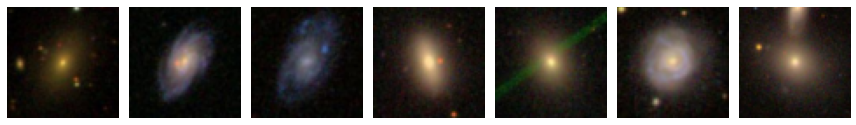

In [ ]:
show_image_row([x_train[0], x_train[1], x_train[2], x_train[3], x_train[4], x_train[5], x_train[6]],plot_size=[12,3])

### Generate training data. We select 3 images as classes and then generate from them new training samples by simply randomly rotating them

In [ ]:

#--- Number of examples per classs
n_in_class = 500

#--- Select first three images as classes
imas_class = imas[0:3]

#--- Number of classes
n_classes = 3

x_all = []
y_all = []
for i in range(n_classes):
    
    x_all = x_all + expand_image(imas[i], n_in_class)
    y_all = y_all + (np.zeros(n_in_class)+i).tolist()

x_all = np.asarray(x_all)
y_all = np_utils.to_categorical(y_all)

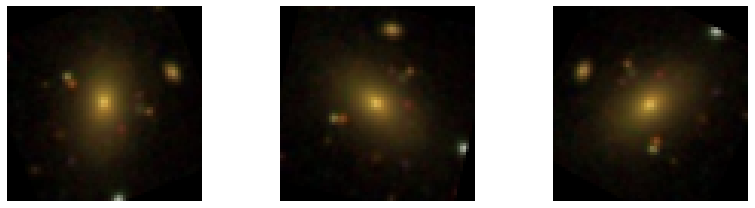

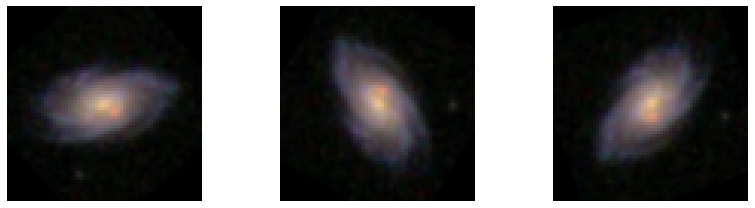

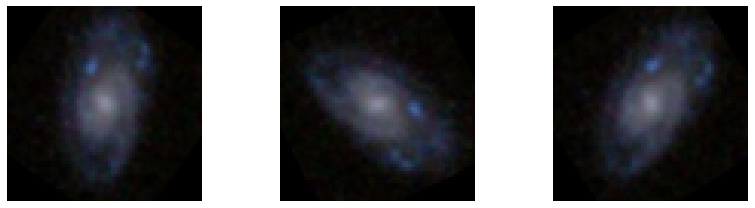

In [ ]:
for i in range(n_classes):
  show_image_row([x_all[i*n_in_class + 0], x_all[i*n_in_class + 1], x_all[i*n_in_class + 2]])

### Instantiate the model and show

In [ ]:
ng = imas.shape[1]
model = get_classifier(ng, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0   

In [ ]:
n_super_epochs = 1
for i in range(n_super_epochs):
    model.fit(x_all, y_all, batch_size=32, epochs=10, verbose=1, shuffle=True, validation_split=0.1)

Train on 1350 samples, validate on 150 samples
Epoch 1/10
1350/1350 [==============================] - 2s 1ms/step - loss: 0.4009 - accuracy: 0.8822 - val_loss: 0.0714 - val_accuracy: 1.0000
Epoch 2/10
1350/1350 [==============================] - 0s 212us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 3/10
1350/1350 [==============================] - 0s 218us/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/10
1350/1350 [==============================] - 0s 206us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 9.2002e-04 - val_accuracy: 1.0000
Epoch 5/10
1350/1350 [==============================] - 0s 210us/step - loss: 3.4817e-04 - accuracy: 1.0000 - val_loss: 2.6206e-04 - val_accuracy: 1.0000
Epoch 6/10
1350/1350 [==============================] - 0s 220us/step - loss: 9.5285e-05 - accuracy: 1.0000 - val_loss: 7.6058e-05 - val_accuracy: 1.0000
Epoch 7/10
1350/1350 [==============================] - 0s 

### Test the classification

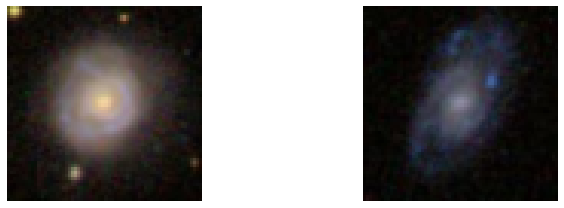

In [ ]:
target_ima = 5

pred = model.predict(imas[target_ima].reshape(1,64,64,3))
top = np.argsort(pred[0])

show_image_row([imas[target_ima], imas_class[top[2]]])

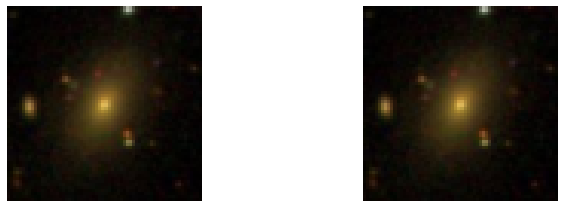

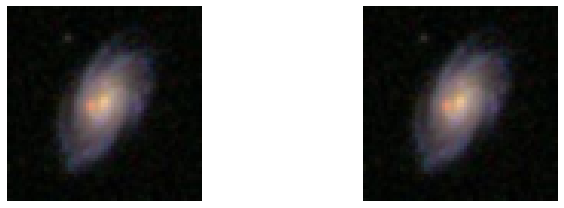

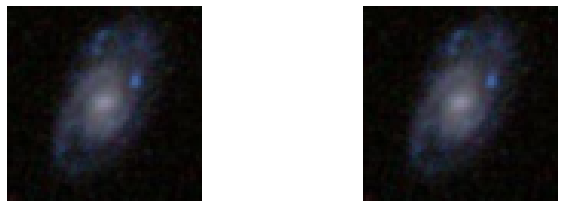

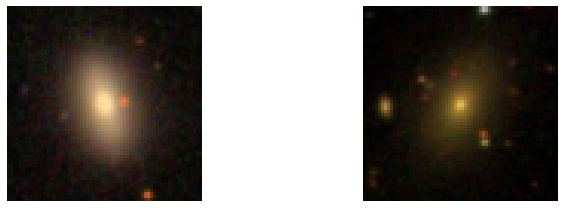

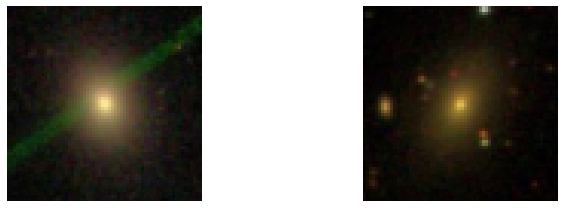

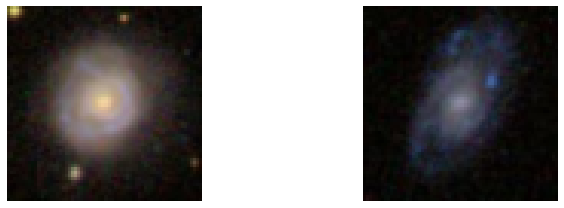

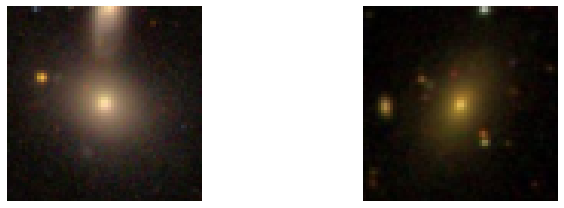

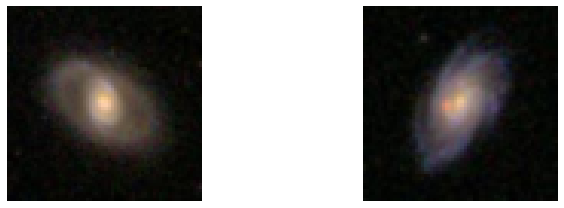

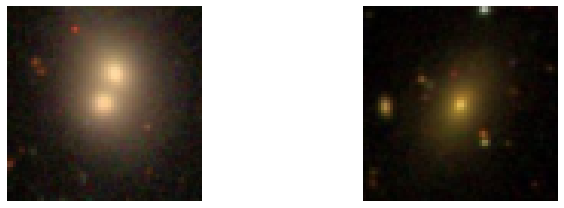

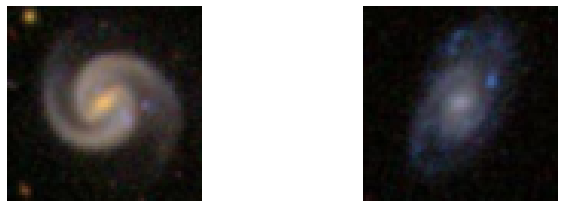

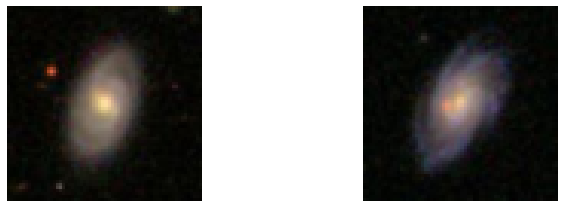

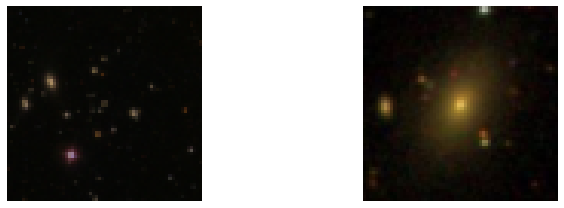

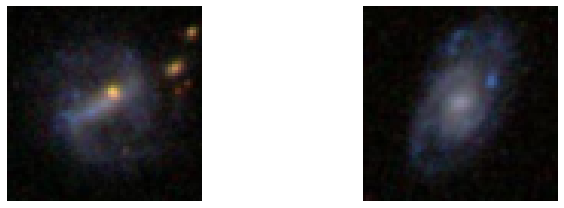

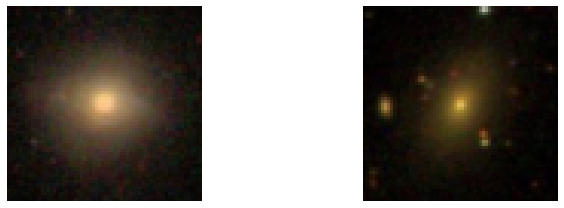

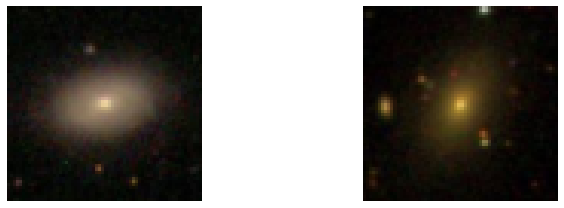

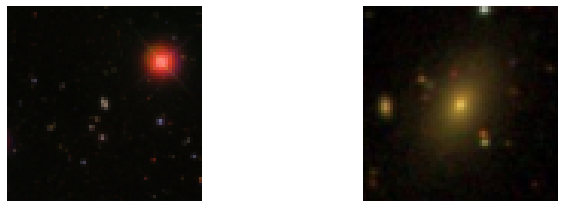

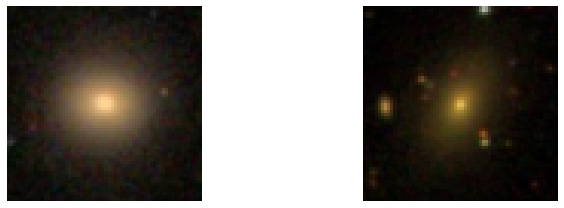

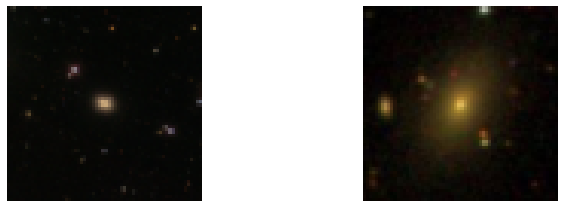

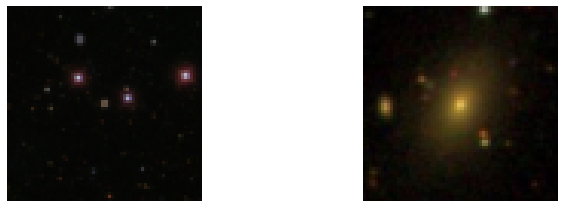

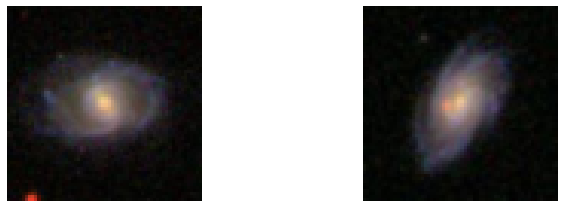

In [ ]:
for i in range(20):
  target_ima = i

  pred = model.predict(imas[target_ima].reshape(1,64,64,3))
  top = np.argsort(pred[0])

  show_image_row([imas[target_ima], imas_class[top[2]]])